---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---
- Estudiante: **Adrián Montero Bonilla**
- Carné: **B85092**
- Grupo: **1/2**
---
- Estudiante: **Luis Alberto Arias Brenes**
- Carné: **B90639**
- Grupo: **2**
---

# Solución del Proyecto 5 - Procesos M/M/s

### Primera parte: Determinación teórica del número  de servidores necesarios para cumplir el requisito.
---
#### Los datos del enunciado son:

$\lambda = 4$

$\nu = 0.25$

Además, se quiere el sistema no exceda 50 personas en fila durante el 95% del tiempo. 

---

Se sabe de la teoría que $\rho = \frac{\lambda}{s\nu}$ y, al sustituir con los datos dados por el enunciado, dicha expresión queda de la siguiente manera:

$$
\rho = \frac{4}{0.25s} = \frac{16}{s} \space \space \space \space \space \space (1)
$$

Por otro lado, recordando la suma de probabilidad de estado estable, con las condiciones anteriormente dadas (menos de 50 personas en fila por el 95% del tiempo), se tiene la siguiente relación:

$$
P( \text{51 o más clientes en el sistema} ) = \sum_{i=51}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{50} (1 - \rho) \rho^i = \rho^{51}
$$

Con esto, se tiene la condición:

$$
\rho^{51} \leq 0.05 \space \space \space \space \space \space (2)
$$

Al sustituir el valor de $\rho$ de la ecuación (1) en (2) se consigue lo siguiente:

$$
\left(\frac{16}{s}\right)^{51} \leq 0.05
$$

A partir de esta ecuación, despejamos para s y obtenemos la cantidad mínima de servidores necesaria para cumplir con los requisitos solicitados.

$$
\frac{16}{s} \leq \sqrt[51]{0.05}
$$

$$
\frac{16}{\sqrt[51]{0.05}} \leq s
$$

$$
s \geq 16.9679
$$

Finalmente, se llega a que se necesitan 17 o más servidores en total (no se pueden tener fracciones de servidores, solamente servidores enteros) para cumplir con todos los requerimientos solicitados para el proceso de vacunación. 

### Segunda parte: Simulación y corroboración del resultado obtenido en la primera parte. 

Se realiza la simulación para los 17 servidores que es el límite que se calculó para cumplir con los requisitos que se piden en el vacunatorio. 


Parámetro lambda = 4.0
Parámetro nu = 0.25
Servidores s = 17
Tiempo con igual o menos de 50 solicitudes:
	 100.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 4.92 horas.


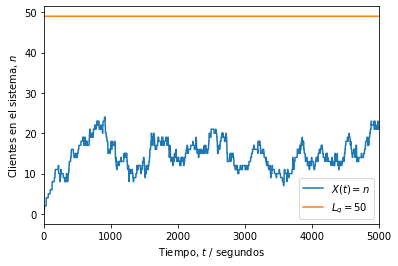

In [30]:
#Librerías de interés
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

'''--------------------------------
   Comprobación de requerimientos  
   --------------------------------
   Parámetros importantes: 
   -lam = Parámetro de llegada
   -nu = Parámetro de llegada de cada cliente
   -s = Cantidad de servidores 
   -N = Cantidad de clientes 
   ---------------------------------'''

N = 1000

lam = 4/60 #(Clientes/segundos)

nu = 0.25/60 #(servicios/segundos)

s = 17

# Distribución de los tiempos de llegada entre cada cliente
# Funcion exponencial es la que mejor describe tiempos de llegada
X = stats.expon(scale = 1/lam)

# Distribución de los tiempos de servicio a cada cliente
Y = stats.expon(scale = 1/(nu)) 

# Intervalos entre llegadas (segundos desde último cliente)
t_intervalos = np.ceil(X.rvs(N)).astype('int')

# Tiempos de las llegadas (segundos desde el inicio)
t_llegadas = [t_intervalos[0]]
for i in range(1, len(t_intervalos)):
    siguiente = t_llegadas[i-1] + t_intervalos[i]
    t_llegadas.append(siguiente)

# Tiempos de servicio (segundos desde inicio de servicio)
t_servicio = np.ceil(Y.rvs(N)).astype('int')

#------------------------------------------
#Vector de servidores
servidores = np.zeros(s)
    
# Inicialización del tiempo de inicio y fin de atención 
inicio = t_llegadas[0]          # primera llegada
fin = inicio + t_servicio[0]    # primera salida
    
# Primer servidor
servidores[0] = fin
    
# Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
t_atencion = [inicio]
    
for h in range(1, N):
    desocupados = np.where(servidores <= t_llegadas[h])[0]
    # Sin espacios disponibles
    if desocupados.size == 0: 
        inicio = np.min(servidores) + 1
        fin = inicio + t_servicio[h]
        minimo = np.min(servidores) # Servidor que atiende
        espacios = servidores.tolist().index(minimo)
        servidores[espacios] = fin
        
    # Si hay espacios desocupados
    else: 
        inicio = t_llegadas[h]
        fin = inicio + t_servicio[h]
        espacios = desocupados[0]
        servidores[espacios] = fin
        
    t_atencion.append(inicio.astype(int))
  
# Inicialización del vector temporal para registrar eventos
t = np.zeros(t_atencion[-1] + max(t_servicio) + 1)

# Asignación de eventos de llegada (+1) y salida (-1) de clientes
for c in range(N):
    i = t_llegadas[c]
    t[i] += 1
    j = t_atencion[c] + t_servicio[c]
    t[j] -= 1

# Umbral de P o más personas en sistema (hay P - 1 en fila)
P = 50

# Instantes (segundos) de tiempo con P o más solicitudes en sistema
exceso = 0

# Proceso aleatorio (estados n = {0, 1, 2...})
Xt = np.zeros(t.shape)

# Inicialización de estado n
n = 0

# Recorrido del vector temporal y conteo de clientes (estado n)
for i, c in enumerate(t):
    n += c # sumar (+1) o restar (-1) al estado
    Xt[i] = n
    if Xt[i] <= P: 
        exceso += 1

# Fracción de tiempo con P o más solicitudes en sistema
fraccion = exceso / len(t)

# Resultados
print('Parámetro lambda =', str(lam*60))
print('Parámetro nu =', str(nu*60))
print('Servidores s =', str(s))
print('Tiempo con igual o menos de {} solicitudes:'.format(P))
print('\t {:0.2f}%'.format(100*fraccion))
if fraccion >= 0.95:
    print('\t Sí cumple con la especificación.')
else:
    print('\t No cumple con la especificación.') 
print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

# Gráfica de X(t) (estados del sistema)
plt.figure()
plt.plot(Xt)
plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
plt.legend(('$X(t) = n$', '$L_q = $' + str(P)))
plt.ylabel('Clientes en el sistema, $n$')
plt.xlabel('Tiempo, $t$ / segundos')
plt.xlim((0, 10000))
plt.show()

Inmediatamente se ejecuta el código para un caso en el que no se estaría cumpliendo con lo necesario, para esto entonces se utilizan 15 servidores 

Parámetro lambda = 4.0
Parámetro nu = 0.25
Servidores s = 16
Tiempo con igual o menos de 50 solicitudes:
	 77.54%
	 No cumple con la especificación.
Simulación es equivalente a 4.64 horas.


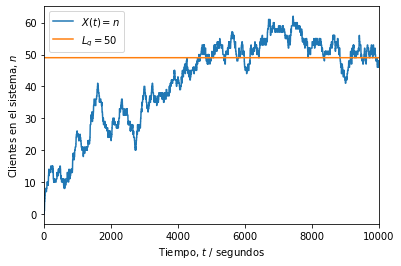

In [37]:
#Librerías de interés
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

'''--------------------------------
   Comprobación de requerimientos  
   --------------------------------
   Parámetros importantes: 
   -lam = Parámetro de llegada
   -nu = Parámetro de llegada de cada cliente
   -s = Cantidad de servidores 
   -N = Cantidad de clientes 
   ---------------------------------'''

N = 1000

lam = 4/60 #(Clientes/segundos)

nu = 0.25/60 #(servicios/segundos)

s = 16

# Distribución de los tiempos de llegada entre cada cliente
# Funcion exponencial es la que mejor describe tiempos de llegada
X = stats.expon(scale = 1/lam)

# Distribución de los tiempos de servicio a cada cliente
Y = stats.expon(scale = 1/(nu)) 

# Intervalos entre llegadas (segundos desde último cliente)
t_intervalos = np.ceil(X.rvs(N)).astype('int')

# Tiempos de las llegadas (segundos desde el inicio)
t_llegadas = [t_intervalos[0]]
for i in range(1, len(t_intervalos)):
    siguiente = t_llegadas[i-1] + t_intervalos[i]
    t_llegadas.append(siguiente)

# Tiempos de servicio (segundos desde inicio de servicio)
t_servicio = np.ceil(Y.rvs(N)).astype('int')

#------------------------------------------
#Vector de servidores
servidores = np.zeros(s)
    
# Inicialización del tiempo de inicio y fin de atención 
inicio = t_llegadas[0]          # primera llegada
fin = inicio + t_servicio[0]    # primera salida
    
# Primer servidor
servidores[0] = fin
    
# Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
t_atencion = [inicio]
    
for h in range(1, N):
    desocupados = np.where(servidores <= t_llegadas[h])[0]
    # Sin espacios disponibles
    if desocupados.size == 0: 
        inicio = np.min(servidores) + 1
        fin = inicio + t_servicio[h]
        minimo = np.min(servidores) # Servidor que atiende
        espacios = servidores.tolist().index(minimo)
        servidores[espacios] = fin
        
    # Si hay espacios desocupados
    else: 
        inicio = t_llegadas[h]
        fin = inicio + t_servicio[h]
        espacios = desocupados[0]
        servidores[espacios] = fin
        
    t_atencion.append(inicio.astype(int))
  
# Inicialización del vector temporal para registrar eventos
t = np.zeros(t_atencion[-1] + max(t_servicio) + 1)

# Asignación de eventos de llegada (+1) y salida (-1) de clientes
for c in range(N):
    i = t_llegadas[c]
    t[i] += 1
    j = t_atencion[c] + t_servicio[c]
    t[j] -= 1

# Umbral de P o más personas en sistema (hay P - 1 en fila)
P = 50

# Instantes (segundos) de tiempo con P o más solicitudes en sistema
exceso = 0

# Proceso aleatorio (estados n = {0, 1, 2...})
Xt = np.zeros(t.shape)

# Inicialización de estado n
n = 0

# Recorrido del vector temporal y conteo de clientes (estado n)
for i, c in enumerate(t):
    n += c # sumar (+1) o restar (-1) al estado
    Xt[i] = n
    if Xt[i] <= P: 
        exceso += 1

# Fracción de tiempo con P o más solicitudes en sistema
fraccion = exceso / len(t)

# Resultados
print('Parámetro lambda =', str(lam*60))
print('Parámetro nu =', str(nu*60))
print('Servidores s =', str(s))
print('Tiempo con igual o menos de {} solicitudes:'.format(P))
print('\t {:0.2f}%'.format(100*fraccion))
if fraccion >= 0.95:
    print('\t Sí cumple con la especificación.')
else:
    print('\t No cumple con la especificación.') 
print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

# Gráfica de X(t) (estados del sistema)
plt.figure()
plt.plot(Xt)
plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
plt.legend(('$X(t) = n$', '$L_q = $' + str(P)))
plt.ylabel('Clientes en el sistema, $n$')
plt.xlabel('Tiempo, $t$ / segundos')
plt.xlim((0, 10000))
plt.show()

A partir de los resultados que se obtuvieron se puede notar que para que el proceso de vacunación cumpla con los requisitos solicitados se debe tener 17 o más servidores en funcionamiento, si esto es así el vacunatorio no va a tener una saturación, cumpliendo con los requisitos que solicita el vacunatorio, así que llegando 4 personas por minuto se va a tener la disponibilidad de servidores suficiente para evitar que haya más de 50 personas en fila durante un noventa y cinco por ciento del tiempo, incluso durante esa simulación  

Por otro lado si se rebaja la cantidad de servidores "al límite" se puede notar como durante un tiempo mayor al cinco por ciento se sobrepasa la cantidad de personas que se espera tener en fila, lo cual afectaría el servicio que se está realizando y por lo tanto no es recomendable usar menos de 17 servidores si se quiere cumplir de forma correcta con los requerimientos  